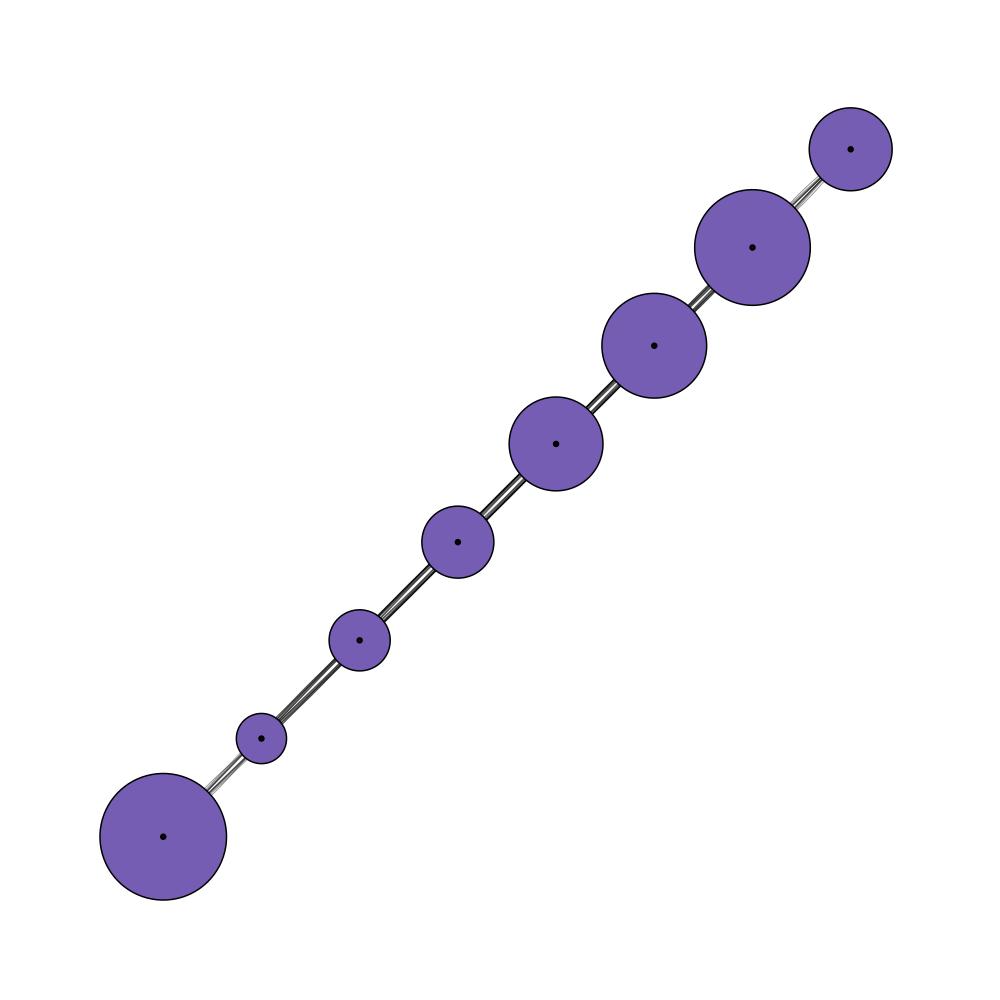

In [10]:
using Agents, Random, DataFrames, LightGraphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict
using Plots

mutable struct PoorSoul <: AbstractAgent
    id::Int
    pos::Int
    days_infected::Int  # number of days since is infected
    status::Symbol      # 1: S, 2: I, 3:R
end

function model_initiation(;
    Ns,
    migration_rates,
    β_und,
    β_det,
    infection_period = 30,
    reinfection_probability = 0.05,
    detection_time = 14,
    death_rate = 0.02,
    Is = [zeros(Int, length(Ns) - 1)..., 1],
    seed = 0,
)

    Random.seed!(seed)
    @assert length(Ns) ==
    length(Is) ==
    length(β_und) ==
    length(β_det) ==
    size(migration_rates, 1) "length of Ns, Is, and B, and number of rows/columns in migration_rates should be the same "
    @assert size(migration_rates, 1) == size(migration_rates, 2) "migration_rates rates should be a square matrix"

    C = length(Ns)
    # normalize migration_rates
    migration_rates_sum = sum(migration_rates, dims = 2)
    for c in 1:C
        migration_rates[c, :] ./= migration_rates_sum[c]
    end

    properties = @dict(
        Ns,
        Is,
        β_und,
        β_det,
        β_det,
        migration_rates,
        infection_period,
        infection_period,
        reinfection_probability,
        detection_time,
        C,
        death_rate
    )
    space = GraphSpace(complete_digraph(C))
    model = ABM(PoorSoul, space; properties = properties)

    # Add initial individuals
    for city in 1:C, n in 1:Ns[city]
        ind = add_agent!(city, model, 0, :S) # Susceptible
    end
    # add infected individuals
    for city in 1:C
        inds = get_node_contents(city, model)
        for n in 1:Is[city]
            agent = model[inds[n]]
            agent.status = :I # Infected
            agent.days_infected = 1
        end
    end
    return model
end

using LinearAlgebra: diagind

function create_params(;
    C,
    max_travel_rate,
    infection_period = 30,
    reinfection_probability = 0.05,
    detection_time = 14,
    death_rate = 0.02,
    Is = [zeros(Int, C - 1)..., 1],
    seed = 19,
)

    Random.seed!(seed)
    Ns = rand(50:5000, C)
    β_und = rand(0.3:0.02:0.6, C)
    β_det = β_und ./ 10

    Random.seed!(seed)
    migration_rates = zeros(C, C)
    for c in 1:C
        for c2 in 1:C
            migration_rates[c, c2] = (Ns[c] + Ns[c2]) / Ns[c]
        end
    end
    maxM = maximum(migration_rates)
    migration_rates = (migration_rates .* max_travel_rate) ./ maxM
    migration_rates[diagind(migration_rates)] .= 1.0

    params = @dict(
        Ns,
        β_und,
        β_det,
        migration_rates,
        infection_period,
        reinfection_probability,
        detection_time,
        death_rate,
        Is
    )

    return params
end

params = create_params(C = 8, max_travel_rate = 0.01)
model = model_initiation(; params...)

using AgentsPlots

xs = 1:model.C
ys = 1:model.C

plotargs = (node_size = 2, x=xs, y=ys , nodeshape=:circle, nodeweights=[8,1,2,3,5,6,7,4], linealpha=0.4, size = (1000, 1000), showaxis = false, aspect_ratio = 1)

plotabm(model; plotargs...)